In [18]:
import numpy as np
import pandas as pd
from joblib import load

# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 5, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [19]:
POS_COUNT = 1319
NEG_COUNT = 1253

In [20]:
palette_models = {  
    'HydrAMP τ=1': '#B80018',
    'HydrAMP τ=2': '#D91115',
    'HydrAMP τ=5': '#660708',         
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
    'Joker': '#0F5257'     
}


TEMPS = {
    'HydrAMP': [1, 2, 5],
    'PepCVAE': [1],
    'Basic': [1],
}

In [21]:
results = {}

In [22]:
# Read HydrAMP, PepCVAE, Basic
for model, temps in TEMPS.items():
    for temp in temps:
        for mode in ['improvement', 'discovery']:
            results[f'{model}_pos_{mode}_{temp}'] = load(f'../../results/pos_dict_{mode}_{model}_{temp}.joblib')
            results[f'{model}_neg_{mode}_{temp}'] = load(f'../../results/neg_dict_{mode}_{model}_{temp}.joblib')
 

In [23]:
# Read Joker 

results['joker_pos_discovery'] = pd.read_csv('../../results/joker_pos_discovery.tsv', sep='\t' )
results['joker_pos_improvement'] = pd.read_csv('../../results/joker_pos_improvement.tsv', sep='\t' )
results['joker_neg_discovery'] = pd.read_csv('../../results/joker_neg_discovery.tsv', sep='\t' )
results['joker_neg_improvement'] = pd.read_csv('../../results/joker_neg_improvement.tsv', sep='\t' )

# Plot

In [24]:
def get_prototypes_with_analogues(result_dict : dict):
    return ({prototype: analogues for prototype, analogues in result_dict.items() \
             if analogues['generated_sequences']})

def get_bars(
    results,
    model,
    temp,
):
    pos_discovery_dict = results[f'{model}_pos_discovery_{temp}']
    pos_improvement_dict =  results[f'{model}_pos_improvement_{temp}']
    neg_discovery_dict = results[f'{model}_neg_discovery_{temp}']
    neg_improvement_dict =  results[f'{model}_neg_improvement_{temp}']   
    
    
    return [
        len(get_prototypes_with_analogues(pos_discovery_dict))/POS_COUNT, 
        len(get_prototypes_with_analogues(pos_improvement_dict))/POS_COUNT,
        len(get_prototypes_with_analogues(neg_discovery_dict))/NEG_COUNT,
        len(get_prototypes_with_analogues(neg_improvement_dict))/NEG_COUNT,
    ]

In [25]:
HydrAMP_means_1 = get_bars(results, 'HydrAMP', '1')
HydrAMP_means_2 = get_bars(results, 'HydrAMP', '2')
HydrAMP_means_5 = get_bars(results, 'HydrAMP', '5')
PepCVAE_means = get_bars(results, 'PepCVAE', '1')
Basic_means = get_bars(results, 'Basic', '1')

joker_means = [
    len(results['joker_pos_discovery'])/POS_COUNT,
    len(results['joker_pos_improvement'])/POS_COUNT,
    len(results['joker_neg_discovery'])/NEG_COUNT,
    len(results['joker_neg_improvement'])/NEG_COUNT,
]


means_list = [
    HydrAMP_means_1,
    HydrAMP_means_2,
    HydrAMP_means_5,
    PepCVAE_means, 
    Basic_means,
    joker_means
]

In [26]:
def autolabel(rects, ax, no_peptides):
    for rect in rects:
        h = rect.get_height()
        ax.text(
            rect.get_x()+rect.get_width()/2.,
            h+0.01,
            '%d'%int(h*no_peptides),
            ha='center',
            va='bottom',
            fontsize=4.5
        )

# Negative improvement - quality metrics

In [27]:
def extract_results(result_dict):
    prototype_amp = [peptide['amp'] for peptide in result_dict.values() if peptide['generated_sequences']]
    prototype_mic = [peptide['mic'] for peptide in result_dict.values() if peptide['generated_sequences']]
    
    analogue_amp = [max([analogue['amp'] for analogue in entry['generated_sequences']])
                for entry in result_dict.values() if entry['generated_sequences']]
    analogue_mic = [max([analogue['mic'] for analogue in entry['generated_sequences']])
                for entry in result_dict.values() if entry['generated_sequences']]
    
    return prototype_amp, prototype_mic, analogue_amp, analogue_mic


def extract_joker_results(result_df):
    prototype_amp = result_df.amp_prototype.to_list()
    prototype_mic = result_df.mic_prototype.to_list()

    analogue_amp = result_df.amp_analogue.to_list()
    analogue_mic = result_df.mic_analogue.to_list()
    
    return prototype_amp, prototype_mic, analogue_amp, analogue_mic

In [28]:
def get_data(results, mode):

    pos_amp = [peptide['amp'] for peptide in results[f'HydrAMP_pos_{mode}_1'].values()]
    pos_mic = [peptide['mic'] for peptide in results[f'HydrAMP_pos_{mode}_1'].values()]

    neg_amp = [peptide['amp'] for peptide in results[f'HydrAMP_neg_{mode}_1'].values()]
    neg_mic = [peptide['mic'] for peptide in results[f'HydrAMP_neg_{mode}_1'].values()]
        
    pos_data = [
        extract_results(results[f'HydrAMP_pos_{mode}_1']),
        extract_results(results[f'HydrAMP_pos_{mode}_2']),
        extract_results(results[f'HydrAMP_pos_{mode}_5']),
        extract_results(results[f'PepCVAE_pos_{mode}_1']),
        extract_results(results[f'Basic_pos_{mode}_1']),
        extract_joker_results(results[f'joker_pos_{mode}']),       
    ]


    neg_data = [
        extract_results(results[f'HydrAMP_neg_{mode}_1']),
        extract_results(results[f'HydrAMP_neg_{mode}_2']),
        extract_results(results[f'HydrAMP_neg_{mode}_5']),
        extract_results(results[f'PepCVAE_neg_{mode}_1']),
        extract_results(results[f'Basic_neg_{mode}_1']),
        extract_joker_results(results[f'joker_neg_{mode}']),         
    ]

    return pos_amp, pos_mic, neg_amp, neg_mic, pos_data, neg_data

In [29]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([3.5])
    ax.set_xticklabels([k])

In [117]:
def generate_classifier_distribution_plot(
    test_amp,
    test_mic,
    prototype_amp,
    prototype_mic,
    analogue_amp,
    analogue_mic,
):
    

    fig, (ax0a, ax1, ax2, ax0b, ax3, ax4) = plt.subplots(
        nrows=1, 
        ncols=6, 
        figsize=(6, 1.5),
        dpi=300,
        sharey=True,
        gridspec_kw={'width_ratios': [1, 6, 6, 1, 6, 6]}
    )

    ax0a_parts = ax0a.violinplot(
        dataset=test_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 

    )

    ax0b_parts = ax0b.violinplot(
        dataset=test_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )
    
    set_axis_style(ax0a, [test_amp], 'AMP and MIC before')
    set_axis_style(ax0b, [test_mic], 'AMP and MIC before')


    for parts, color in zip([ax0a_parts, ax0b_parts], ['#ffd23f', '#540d6e']):
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)   

    for ax in [ax0a, ax0b]:
        ax.set_xticks([1])
        ax.set_xticklabels(['Test data'])

    ax0a.set_ylabel('$P_{M_{AMP}}$')
    ax0b.set_ylabel('$P_{M_{MIC}}$')


    parts1 = ax1.violinplot(
        dataset=prototype_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax1, prototype_amp, 'Prototypes')


    parts2 = ax2.violinplot(
        dataset=analogue_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax2, analogue_amp, 'Analogues')



    parts3 = ax3.violinplot(
        dataset=prototype_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax3, prototype_mic, 'Prototypes')

    parts4 = ax4.violinplot(
        dataset=analogue_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )
    set_axis_style(ax4, analogue_mic, 'Analogues')

    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['left'].set_visible(False)

    for parts in [parts1, parts2, parts3, parts4]:
        for pc, color in zip(parts['bodies'], palette_models.values()):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)
    
    for i, (label, ax) in enumerate(
    zip(['a', 'b'], [ax0a, ax0b])
    ):
        ax.annotate(label, xy=(-0.05, 1.2), xycoords='axes fraction',
          fontweight='bold', va='top', ha='right')

    return fig

In [118]:
def plot_classifier_distribution(data, test_amp, test_mic):
    
    prototype_amp = [x[0] for x in data]
    prototype_mic = [x[1] for x in data]
    analogue_amp = [x[2] for x in data]
    analogue_mic = [x[3] for x in data]
    
    fig = generate_classifier_distribution_plot(
        test_amp,
        test_mic,
        prototype_amp,
        prototype_mic,
        analogue_amp,
        analogue_mic,
    )

    return fig

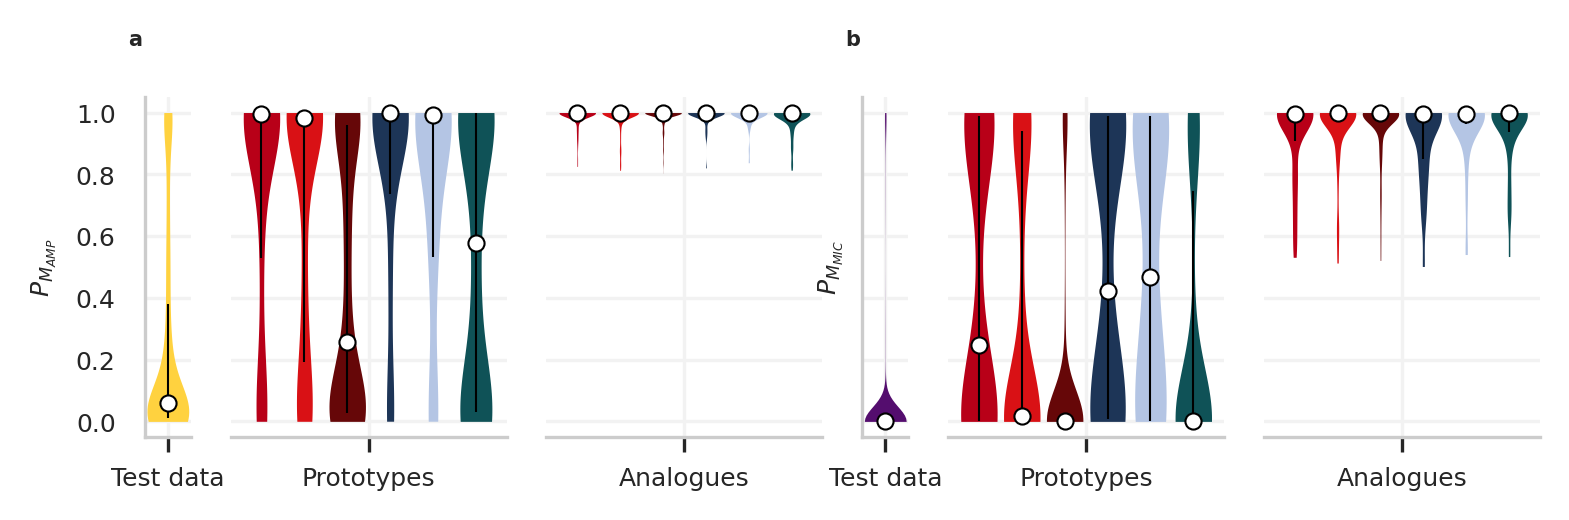

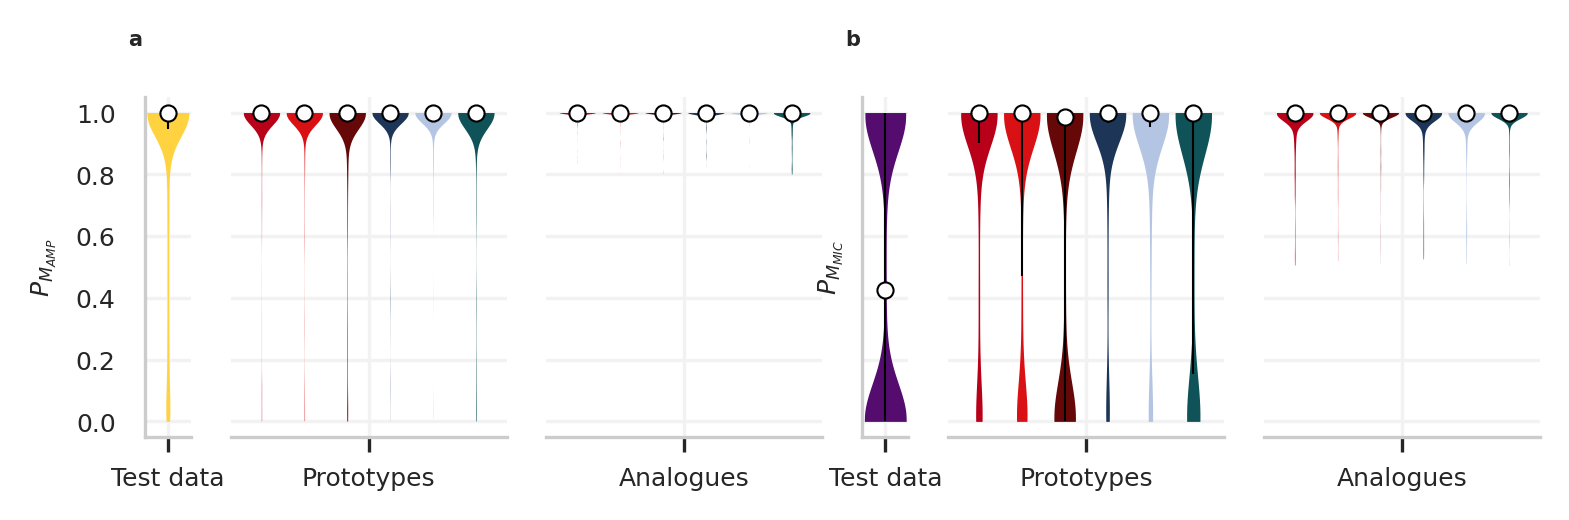

In [119]:
pos_amp, pos_mic, neg_amp, neg_mic, pos_data, neg_data = get_data(results, 'discovery')

fig = plot_classifier_distribution(neg_data, neg_amp, neg_mic)
plt.show()
fig.savefig("../../figures/NegBaseline.svg")

fig = plot_classifier_distribution(pos_data, pos_amp, pos_mic)
plt.show()
fig.savefig("../../figures/PosBaseline.svg")




In [120]:
test_data_dict = {}

for name, item in zip(
    ['positives_amp', 'positives_mic', 'negatives_amp', 'negatives_mic'],
    [pos_amp, pos_mic, neg_amp, neg_mic]):
    test_data_dict[name] = np.quantile(item, [0.25, 0.5, 0.75])
    
df = pd.DataFrame.from_dict(test_data_dict)
df.index = [25, 50, 75]
df.to_csv('SourceData_Figure3_testdata.csv')

In [121]:

def get_quantiles(data, mode='neg'):

    hydramp_1, hydramp_2, hydramp_5 = data[:3]
    pepcvae, basic, joker =  data[3:]

    prototype_amp_dict = {}
    prototype_mic_dict = {}
    analogue_amp_dict = {}
    analogue_mic_dict = {}

    for model_name, model_results in zip(
        ['HydrAMP tau=1', 'HydrAMP tau=2', 'HydrAMP tau=5', 'PepCVAE', 'Basic', 'Joker'],
        [hydramp_1, hydramp_2, hydramp_5, pepcvae, basic, joker]):

        prototype_amp, prototype_mic, analogue_amp, analogue_mic = model_results
        
        prototype_amp_dict[f'{model_name}'] = np.quantile(prototype_amp, [0.25, 0.5, 0.75])
        prototype_mic_dict[f'{model_name}'] = np.quantile(prototype_mic, [0.25, 0.5, 0.75])
        analogue_amp_dict[f'{model_name}'] = np.quantile(analogue_amp, [0.25, 0.5, 0.75])
        analogue_mic_dict[f'{model_name}'] = np.quantile(analogue_mic, [0.25, 0.5, 0.75])
        
        frames = []
        for dict_frame in [prototype_amp_dict, analogue_amp_dict, prototype_mic_dict, analogue_mic_dict]:
            df = pd.DataFrame.from_dict(dict_frame)
            df.index = [25, 50, 75]
            frames.append(df)

        df = pd.concat(frames, keys=['prototype_amp', 'analogue_amp', 'prototype_mic', 'analogue_mic'])
        
    return df
    

In [122]:
neg_df = get_quantiles(neg_data)
pos_df = get_quantiles(pos_data)

neg_df.to_csv('SourceData_Figure3ab.csv')
pos_df.to_csv('SourceData_Figure3ef.csv')

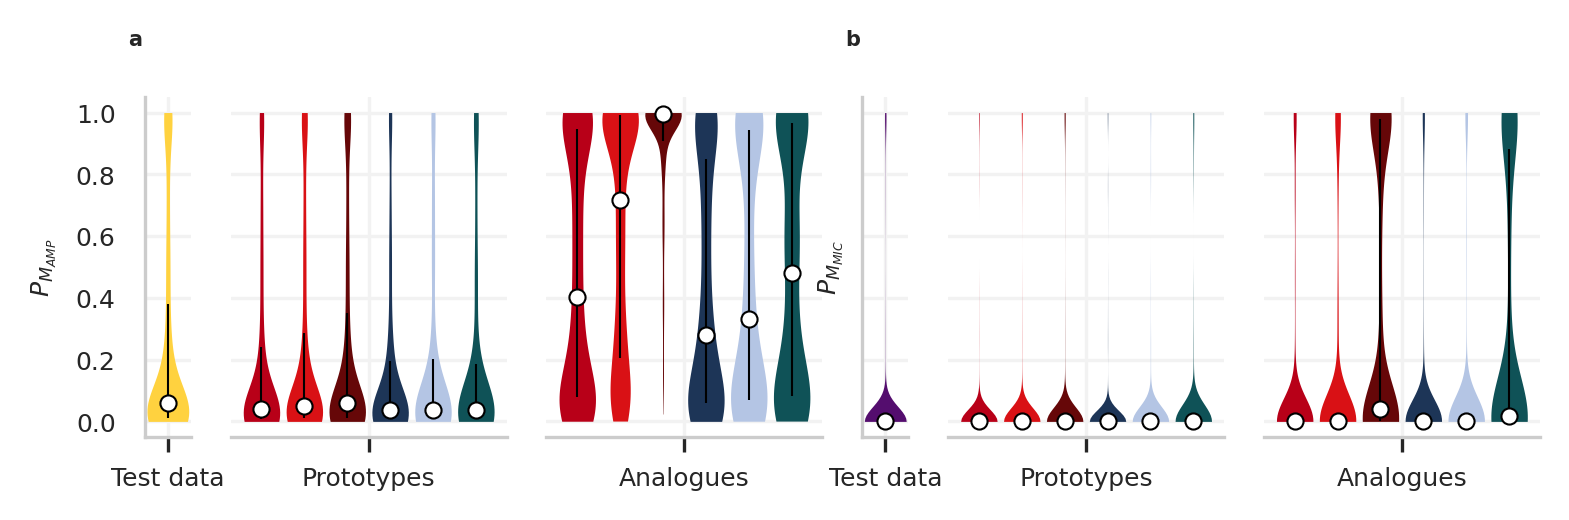

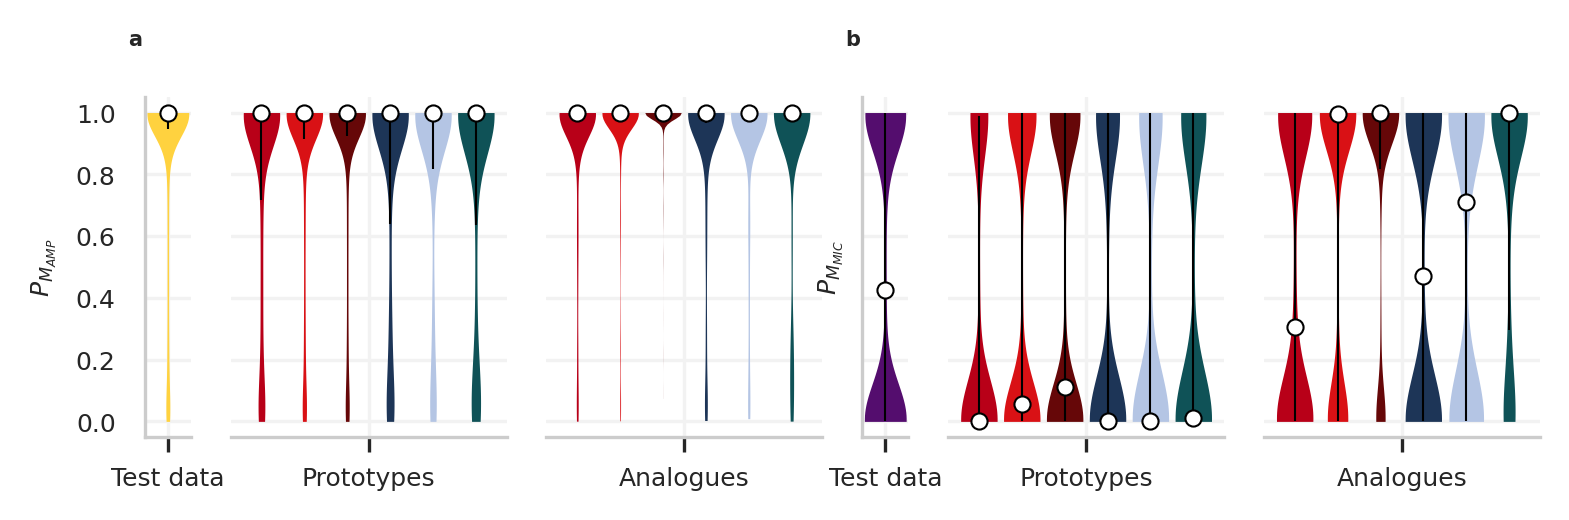

In [123]:
pos_amp, pos_mic, neg_amp, neg_mic, pos_data, neg_data = get_data(results, 'improvement')

fig = plot_classifier_distribution(neg_data, neg_amp, neg_mic)
plt.show()
fig.savefig("../../figures/NegImprovement.svg")


fig = plot_classifier_distribution(pos_data, pos_amp, pos_mic)
plt.show()
fig.savefig("../../figures/PosImprovement.svg")



In [124]:
neg_df = get_quantiles(neg_data)
pos_df = get_quantiles(pos_data)

neg_df.to_csv('SourceData_Figure3cd.csv')
pos_df.to_csv('SourceData_Figure3gh.csv')